In [1]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 99.8 MB/s eta 0:00:00


In [2]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score
from tensorflow.keras import layers, Model, Input
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_folder = '/content/drive/MyDrive/Cellula internship/Week3/data'
images_folder = os.path.join(data_folder, 'images')
labels_folder = os.path.join(data_folder, 'labels')

In [5]:
image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
label_files = [f for f in os.listdir(labels_folder) if os.path.isfile(os.path.join(labels_folder, f))]
images3 = []
labels3 = []
image_files.sort()
label_files.sort()

print("Loading images...")
for image_file in image_files:
    try:
        img_path = os.path.join(images_folder, image_file)
        with rasterio.open(img_path) as src:
            img_data = src.read()  # (C, H, W)
            img_data = np.moveaxis(img_data, 0, -1)  # (H, W, C)
            images3.append(img_data)
        print(f"Loaded image: {image_file}")
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")


print("\nLoading labels...")
for label_file in label_files:
    try:
        label_path = os.path.join(labels_folder, label_file)
        with rasterio.open(label_path) as src:
            label_data = src.read()  # (1, H, W)
            label_data = label_data.squeeze()  # (H, W)
            label_data = (label_data > 0).astype(np.uint8)  # Ensure binary
            labels3.append(label_data)
        print(f"Loaded label: {label_file}")
    except Exception as e:
        print(f"Error loading label {label_file}: {e}")

print(f"\nLoaded {len(images3)} images and {len(labels3)} labels.")


Loading images...


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Loaded image: 0.tif
Loaded image: 1.tif
Loaded image: 10.tif
Loaded image: 100.tif
Loaded image: 101.tif
Loaded image: 102.tif
Loaded image: 103.tif
Loaded image: 104.tif
Loaded image: 105.tif
Loaded image: 106.tif
Loaded image: 107.tif
Loaded image: 108.tif
Loaded image: 109.tif
Loaded image: 11.tif
Loaded image: 110.tif
Loaded image: 111.tif
Loaded image: 112.tif
Loaded image: 113.tif
Loaded image: 114.tif
Loaded image: 115.tif
Loaded image: 116.tif
Loaded image: 117.tif
Loaded image: 118.tif
Loaded image: 119.tif
Loaded image: 12.tif
Loaded image: 120.tif
Loaded image: 121.tif
Loaded image: 122.tif
Loaded image: 123.tif
Loaded image: 124.tif
Loaded image: 125.tif
Loaded image: 126.tif
Loaded image: 127.tif
Loaded image: 128.tif
Loaded image: 129.tif
Loaded image: 13.tif
Loaded image: 130.tif
Loaded image: 131.tif
Loaded image: 132.tif
Loaded image: 133.tif
Loaded image: 134.tif
Loaded image: 135.tif
Loaded image: 136.tif
Loaded image: 137.tif
Loaded image: 138.tif
Loaded image: 139.

In [6]:
image_files_remaining = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
label_files_remaining = [f for f in os.listdir(labels_folder) if os.path.isfile(os.path.join(labels_folder, f))]

# Ensure that the image and label lists only contain files that exist after the move operation
# We can do this by reconstructing images3 and labels3 based on the remaining files
images3_filtered = []
labels3_filtered = []

image_files_remaining.sort()
label_files_remaining.sort()

# Create a set of the base names of the remaining image files for quick lookup
image_basenames_remaining = {os.path.splitext(f)[0] for f in image_files_remaining}

print("Filtering images and labels...")
# Filter images3 based on remaining image files
for img_data, img_file in zip(images3, sorted(image_files, key=lambda f: os.path.splitext(f)[0])):
    if os.path.splitext(img_file)[0] in image_basenames_remaining:
        images3_filtered.append(img_data)
    else:
        print(f"Skipping image {img_file} as its corresponding label was removed.")

# Filter labels3 based on remaining label files (which now correspond to the remaining images)
# We can use the same image_basenames_remaining set because we moved labels that didn't have a matching image
for label_data, label_file in zip(labels3, sorted(label_files, key=lambda f: os.path.splitext(f)[0])):
     if os.path.splitext(label_file)[0] in image_basenames_remaining:
         labels3_filtered.append(label_data)
     else:
         print(f"Skipping label {label_file} as it was moved.")


images3 = images3_filtered
labels3 = labels3_filtered

print(f"\nFiltered {len(images3)} images and {len(labels3)} labels.")

data = pd.DataFrame({"image": images3, "mask": labels3})
display(data.head())

Filtering images and labels...
Skipping label 100_184.png as it was moved.
Skipping label 101_89.png as it was moved.
Skipping label 102_179.png as it was moved.
Skipping label 103_225.png as it was moved.
Skipping label 104_20.png as it was moved.
Skipping label 105_148.png as it was moved.
Skipping label 106_267.png as it was moved.
Skipping label 107_59.png as it was moved.
Skipping label 108_236.png as it was moved.
Skipping label 109_223.png as it was moved.
Skipping label 10_244.png as it was moved.
Skipping label 110_287.png as it was moved.
Skipping label 111_121.png as it was moved.
Skipping label 112_78.png as it was moved.
Skipping label 113_44.png as it was moved.
Skipping label 114_220.png as it was moved.
Skipping label 115_49.png as it was moved.
Skipping label 116_250.png as it was moved.
Skipping label 117_97.png as it was moved.
Skipping label 118_125.png as it was moved.
Skipping label 119_222.png as it was moved.
Skipping label 11_116.png as it was moved.
Skipping l

,image,mask
0,"[[[131, 48, 73, 74, 360, 236, 120, 64, 277, 31...","[[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[[233, 182, 405, 218, 3351, 1717, 705, 128, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[[655, 599, 656, 725, 1005, 2088, 2034, 64, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[[577, 717, 1109, 1295, 2963, 3060, 2148, 64,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[[216, 246, 526, 412, 3370, 2061, 975, 64, 69...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [7]:
for i in range(len(images3)):
    if images3[i].shape[:2] != labels3[i].shape:
        print(f"Shape mismatch at index {i}: Image {images3[i].shape}, Label {labels3[i].shape}")
    else:
        print(f"Shape match at index {i}: Image {images3[i].shape}, Label {labels3[i].shape}")


Shape match at index 0: Image (128, 128, 12), Label (128, 128)
Shape match at index 1: Image (128, 128, 12), Label (128, 128)
Shape match at index 2: Image (128, 128, 12), Label (128, 128)
Shape match at index 3: Image (128, 128, 12), Label (128, 128)
Shape match at index 4: Image (128, 128, 12), Label (128, 128)
Shape match at index 5: Image (128, 128, 12), Label (128, 128)
Shape match at index 6: Image (128, 128, 12), Label (128, 128)
Shape match at index 7: Image (128, 128, 12), Label (128, 128)
Shape match at index 8: Image (128, 128, 12), Label (128, 128)
Shape match at index 9: Image (128, 128, 12), Label (128, 128)
Shape match at index 10: Image (128, 128, 12), Label (128, 128)
Shape match at index 11: Image (128, 128, 12), Label (128, 128)
Shape match at index 12: Image (128, 128, 12), Label (128, 128)
Shape match at index 13: Image (128, 128, 12), Label (128, 128)
Shape match at index 14: Image (128, 128, 12), Label (128, 128)
Shape match at index 15: Image (128, 128, 12), Lab

In [8]:
print("Image shape:", images3[0].shape)   # Expected: (128, 128, 12)
print("Label shape:", labels3[0].shape)   # Expected: (128, 128)
print("Unique values in label:", np.unique(labels3[0]))  # Should be [0, 1]
print("--------"*20)
print("Image list len:", len(images3))
print("Label list len:", len(labels3))

Image shape: (128, 128, 12)
Label shape: (128, 128)
Unique values in label: [0 1]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Image list len: 306
Label list len: 306


In [9]:
images3[0][0, :, :] # (12, 128, 128)


array([[131,  48,  73, ..., 316,  80,   0],
       [142,  41,  74, ..., 316,  80,   0],
       [142,  50,  88, ..., 317,  30,   0],
       ...,
       [276, 234, 451, ..., 256,  10,   0],
       [276, 241, 479, ..., 250,  10,   0],
       [269, 230, 416, ..., 247,  10,   0]], dtype=int16)

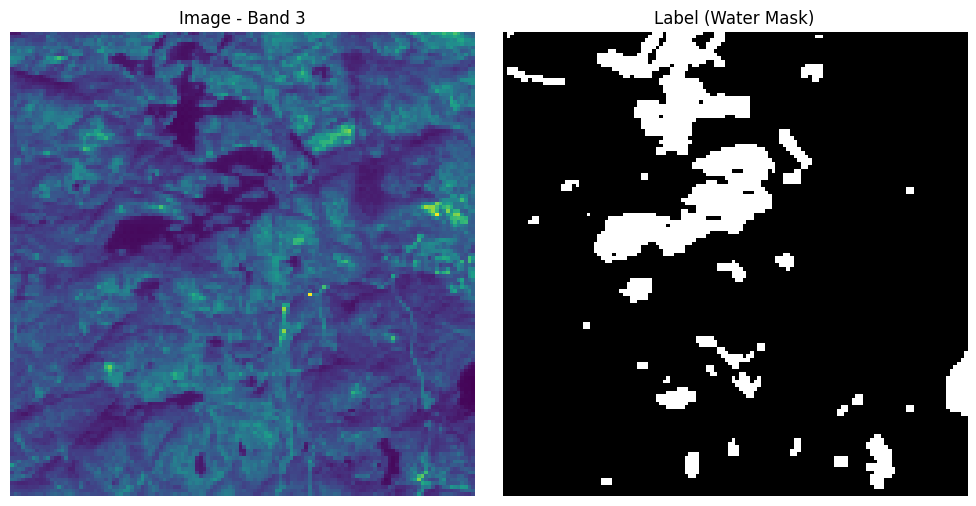

In [10]:
import matplotlib.pyplot as plt

index = 0
image = images3[index][:, :, 3]
mask = labels3[index]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Image - Band {3}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Label (Water Mask)")
plt.axis('off')

plt.tight_layout()
plt.show()


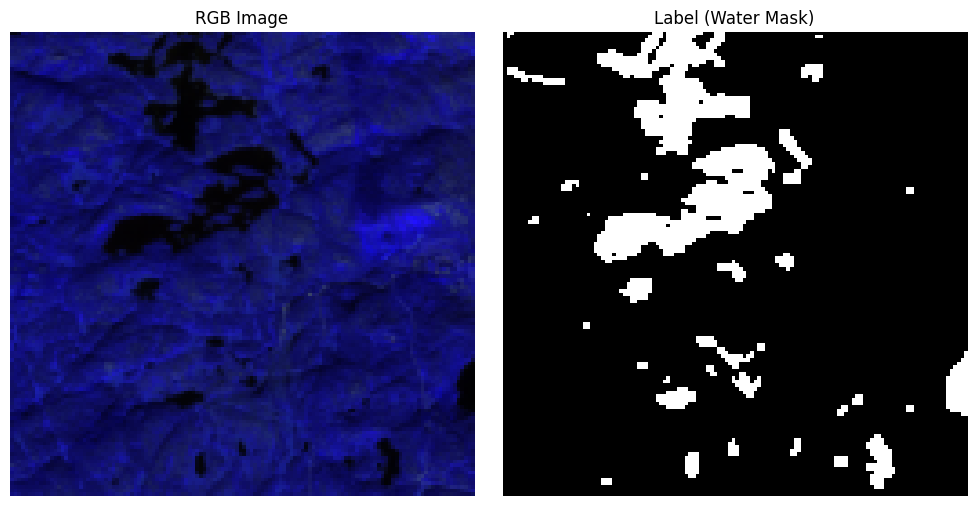

In [11]:
rgb_image = images3[0][:, :, [2,3,4]]

max_val = np.max(rgb_image)
if max_val > 0:
  rgb_image_normalized = rgb_image / max_val
else:
  rgb_image_normalized = rgb_image

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image_normalized)
plt.title("RGB Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(labels3[index], cmap='gray')
plt.title("Label (Water Mask)")
plt.axis('off')

plt.tight_layout()
plt.show()

 Key bands for water detection:
NIR (Band 8) → water absorbs NIR → low reflectance

SWIR (Bands 11 & 12) → water also absorbs SWIR → even lower reflectance

Green (Band 3) → water can be slightly reflective



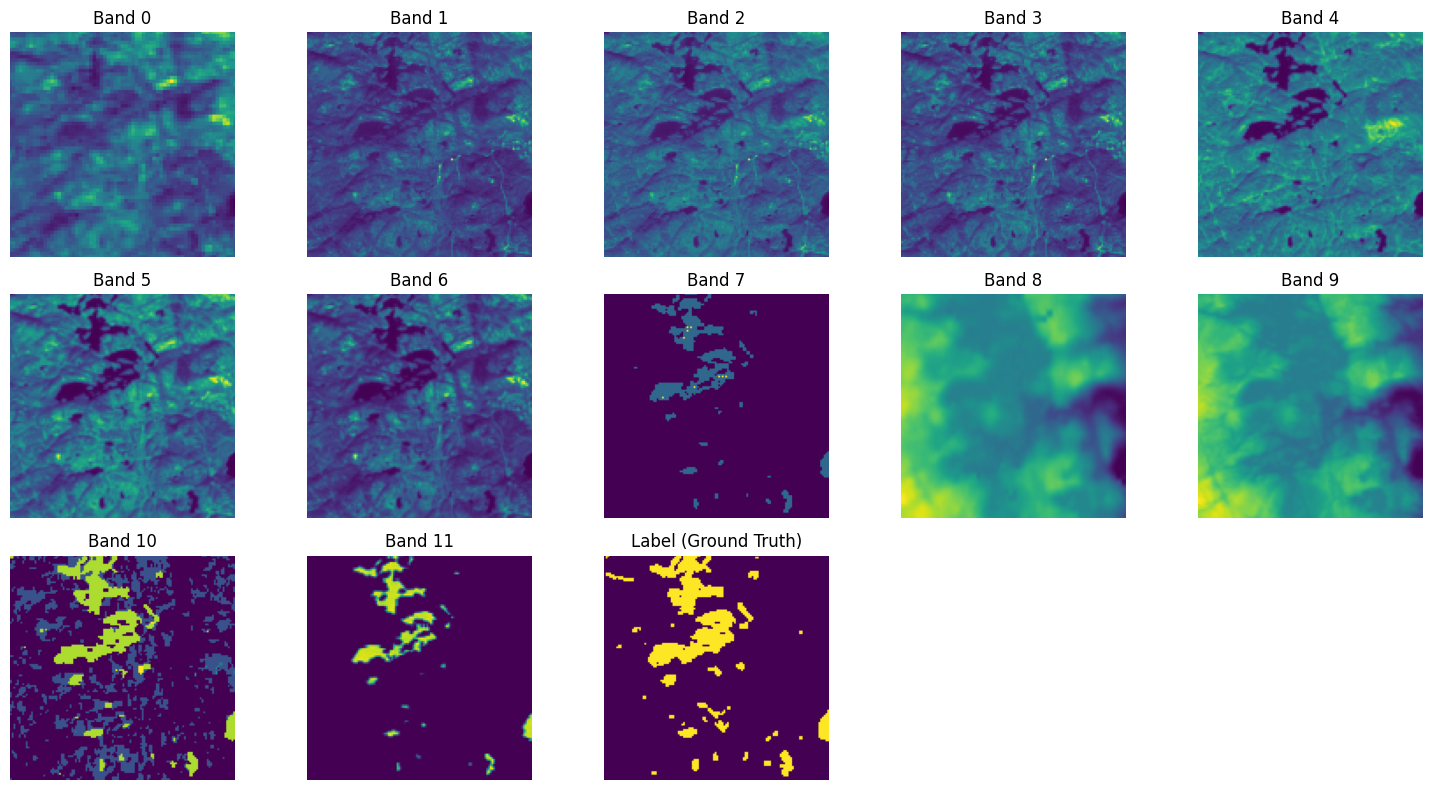

In [12]:
def visualize_bands_and_label(image, label, num_bands=12):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 5, figsize=(15, 8))  # 12 bands + 1 label = 13 plots
    axs = axs.flatten()

    for i in range(num_bands):
        axs[i].imshow(image[:, :, i])
        axs[i].set_title(f"Band {i}")
        axs[i].axis('off')

    axs[num_bands].imshow(label)
    axs[num_bands].set_title("Label (Ground Truth)")
    axs[num_bands].axis('off')

    # Hide any remaining subplots
    for j in range(num_bands + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

visualize_bands_and_label(images3[0], labels3[0])

# Normalize data and apply Augmentation

In [14]:
import tensorflow as tf

images3_tf = tf.data.Dataset.from_tensor_slices(images3)
labels3_tf = tf.data.Dataset.from_tensor_slices(labels3)

dataset = tf.data.Dataset.zip((images3_tf, labels3_tf))

print("Created TensorFlow dataset.")

Created TensorFlow dataset.


In [16]:
def augment(image, mask):
    mask = tf.expand_dims(mask, axis=-1) # (H, W, 1)

    # Random flips
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotations
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)

    # Random zoom (using random crop and resize)
    IMG_HEIGHT = tf.shape(image)[0]
    IMG_WIDTH = tf.shape(image)[1]
    zoom_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.0)
    crop_height = tf.cast(tf.cast(IMG_HEIGHT, tf.float32) * zoom_factor, tf.int32)
    crop_width = tf.cast(tf.cast(IMG_WIDTH, tf.float32) * zoom_factor, tf.int32)

    # Ensure crop size is at least 1x1
    crop_height = tf.maximum(1, crop_height)
    crop_width = tf.maximum(1, crop_width)

    # Ensure crop size does not exceed image size
    crop_height = tf.minimum(crop_height, IMG_HEIGHT)
    crop_width = tf.minimum(crop_width, IMG_WIDTH)

    # Pad if necessary to ensure crop size is not larger than image size
    # This can happen if zoom_factor is close to 1 and image size is small
    padding_h = tf.maximum(0, crop_height - IMG_HEIGHT)
    padding_w = tf.maximum(0, crop_width - IMG_WIDTH)
    image = tf.pad(image, [[0, padding_h], [0, padding_w], [0, 0]], mode='REFLECT')
    mask = tf.pad(mask, [[0, padding_h], [0, padding_w], [0, 0]], mode='REFLECT')

    # Adjust IMG_HEIGHT and IMG_WIDTH to padded dimensions if padding was applied
    IMG_HEIGHT = tf.shape(image)[0]
    IMG_WIDTH = tf.shape(image)[1]

    image = tf.image.random_crop(image, size=[crop_height, crop_width, tf.shape(image)[-1]])
    mask = tf.image.random_crop(mask, size=[crop_height, crop_width, tf.shape(mask)[-1]]) # Mask needs channel dim for random_crop

    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # Use nearest neighbor for masks

    # Remove channel dimension from mask after augmentations
    mask = tf.squeeze(mask, axis=-1) # (H, W)

    return image, mask

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 65535.0
    mask = tf.cast(mask, tf.uint8)
    return image, mask

normalized_dataset = dataset.map(normalize)
augmented_dataset = normalized_dataset.map(augment)

print("Normalized and augmented datasets created successfully.")

Normalized and augmented datasets created successfully.


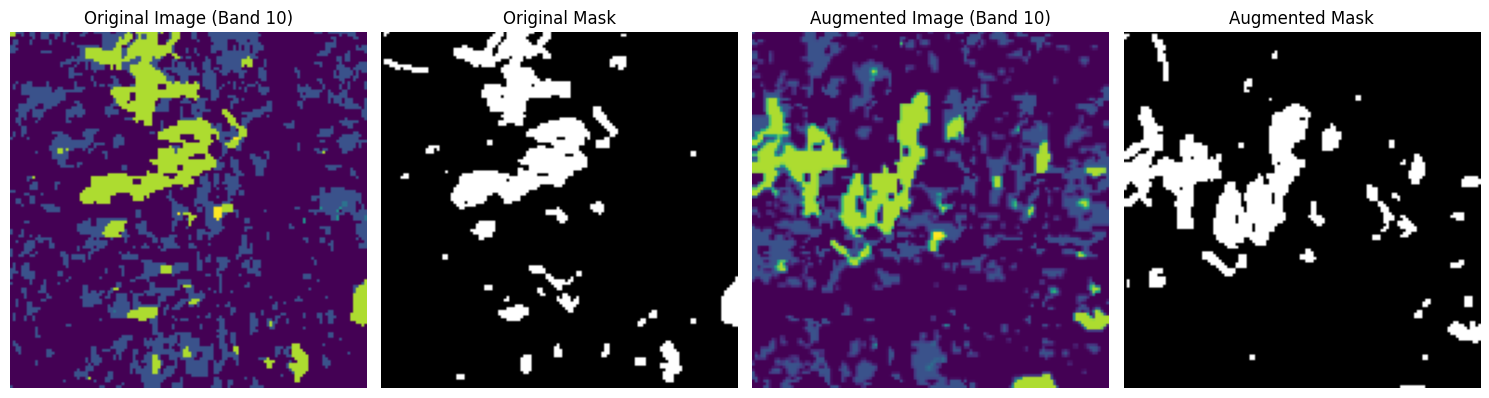

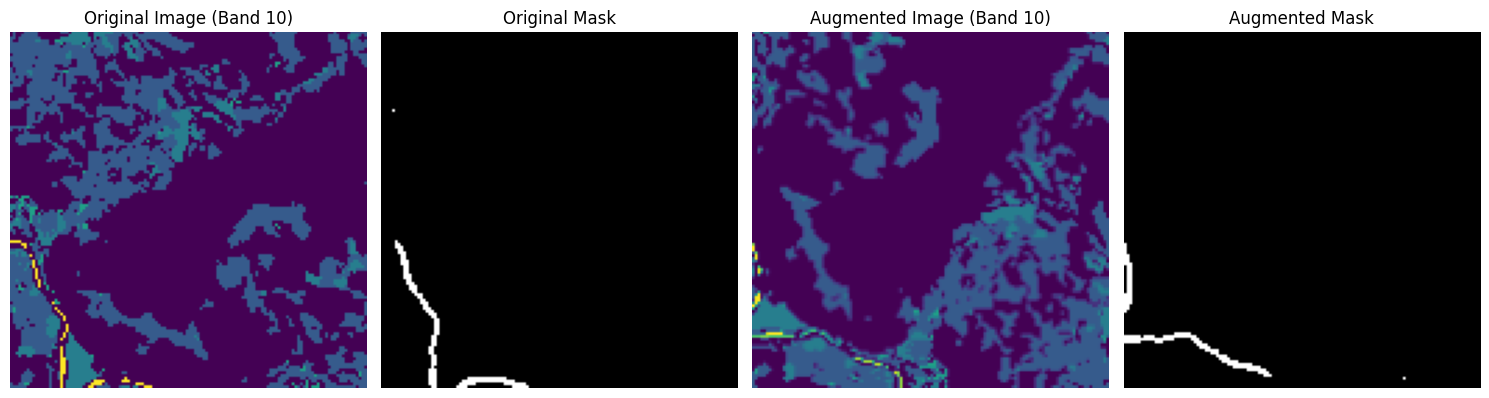

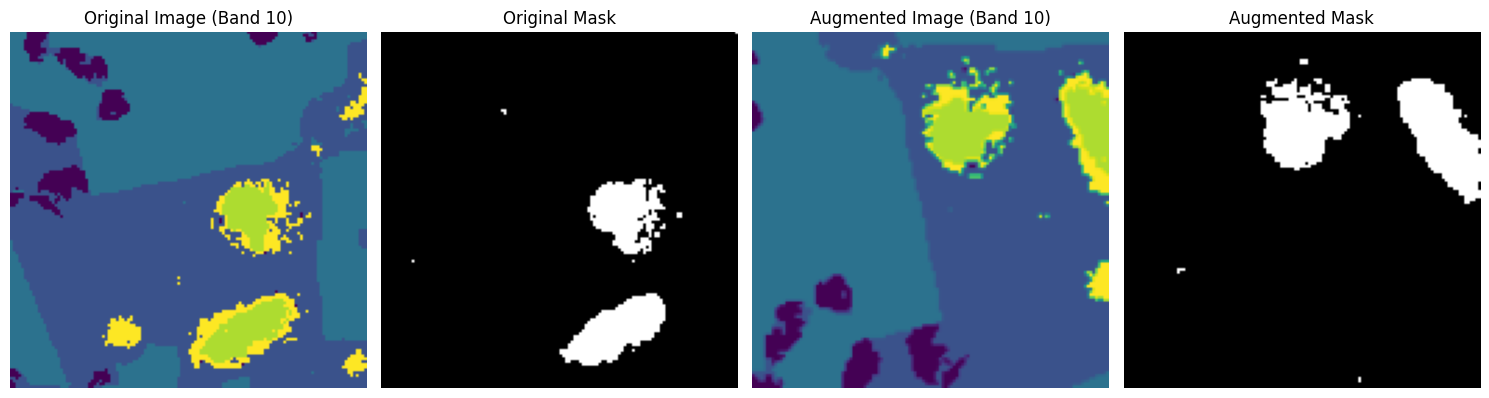

In [26]:
import matplotlib.pyplot as plt

def display_augmentation_examples(original_ds, augmented_ds, num_examples=5):
    original_batch = original_ds.take(num_examples)
    augmented_batch = augmented_ds.take(num_examples)

    for (orig_img, orig_mask), (aug_img, aug_mask) in zip(original_batch, augmented_batch):
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))

        orig_img_np = orig_img.numpy()
        orig_mask_np = orig_mask.numpy()
        aug_img_np = aug_img.numpy()
        aug_mask_np = aug_mask.numpy()

        axs[0].imshow(orig_img_np[:, :, 10])
        axs[0].set_title("Original Image (Band 10)")
        axs[0].axis('off')

        axs[1].imshow(orig_mask_np, cmap='gray')
        axs[1].set_title("Original Mask")
        axs[1].axis('off')

        axs[2].imshow(aug_img_np[:, :, 10])
        axs[2].set_title("Augmented Image (Band 10)")
        axs[2].axis('off')

        axs[3].imshow(aug_mask_np, cmap='gray')
        axs[3].set_title("Augmented Mask")
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()

display_augmentation_examples(normalized_dataset, augmented_dataset, num_examples=3)


# Models:

##unet model:

In [20]:
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [18]:
DATASET_SIZE = len(images3)
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
BATCH_SIZE = 16
BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset = augmented_dataset.take(TRAIN_SIZE)
val_dataset = augmented_dataset.skip(TRAIN_SIZE)

train_dataset = train_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=BUFFER_SIZE)

print(f"Training dataset size: {tf.data.experimental.cardinality(train_dataset).numpy() * BATCH_SIZE}")
print(f"Validation dataset size: {tf.data.experimental.cardinality(val_dataset).numpy() * BATCH_SIZE}")

Training dataset size: 256
Validation dataset size: 64


In [21]:
input_shape = images3[0].shape
print(f"Input shape for the model: {input_shape}")

model = unet_model(input_size=input_shape)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

model.summary()

Input shape for the model: (128, 128, 12)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
EPOCHS = 20

history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)
print("Model training completed.")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, None, None, 12))
  warnings.warn(msg)


16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.6116 - loss: 0.6778 - mean_io_u: 0.3689 - val_accuracy: 0.7638 - val_loss: 0.5620 - val_mean_io_u: 0.3819
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.7530 - loss: 0.5284 - mean_io_u: 0.3689 - val_accuracy: 0.8828 - val_loss: 0.3952 - val_mean_io_u: 0.3819
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.8806 - loss: 0.3868 - mean_io_u: 0.3689 - val_accuracy: 0.8832 - val_loss: 0.3364 - val_mean_io_u: 0.3819
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.8807 - loss: 0.3525 - mean_io_u: 0.3689 - val_accuracy: 0.8828 - val_loss: 0.3313 - val_mean_io_u: 0.3819
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.8812 - loss: 0.3432 - mean_io_u: 0.3689 - val_accuracy: 0.8840 - val_loss: 0.3189 - val_mean_io_u: 0.3819
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.8824 - loss: 0.3313 - mean_io_u: 0.3689 - val_accuracy: 0.8830 - val_loss: 0.3235 - val

In [23]:
evaluation_results = model.evaluate(val_dataset)

print("\nEvaluation Results on Validation Dataset:")
print(f"  Loss: {evaluation_results[0]:.4f}")
print(f"  Accuracy: {evaluation_results[1]:.4f}")
print(f"  MeanIoU: {evaluation_results[2]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8858 - loss: 0.2810 - mean_io_u: 0.3788

Evaluation Results on Validation Dataset:
  Loss: 0.2855
  Accuracy: 0.8880
  MeanIoU: 0.3819


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


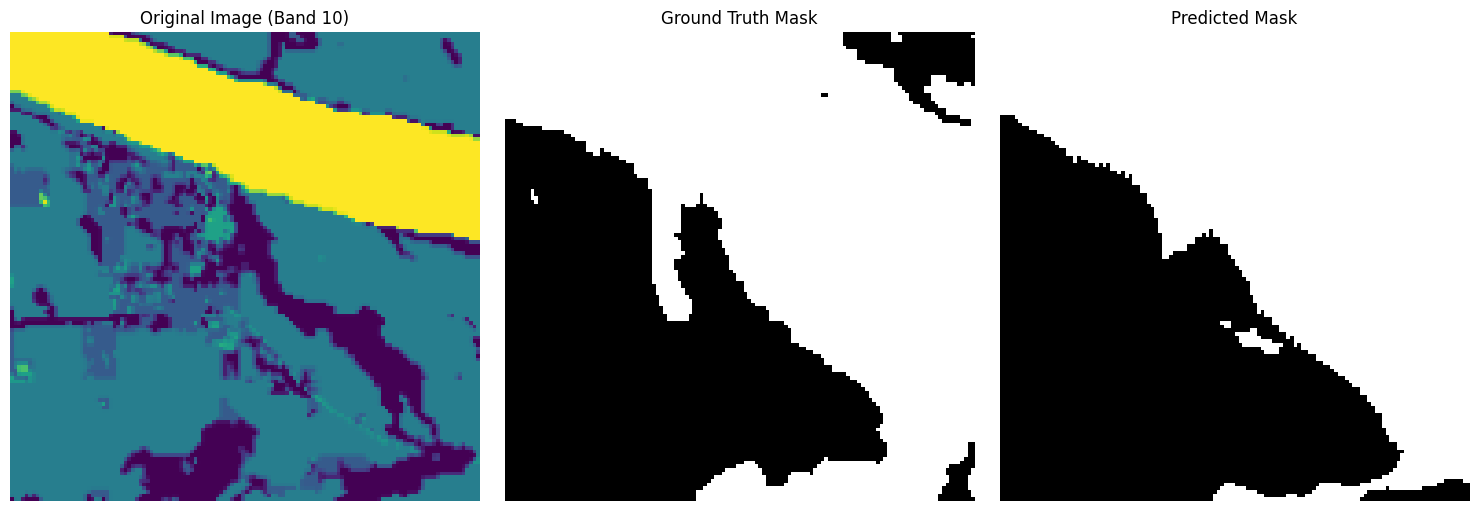

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


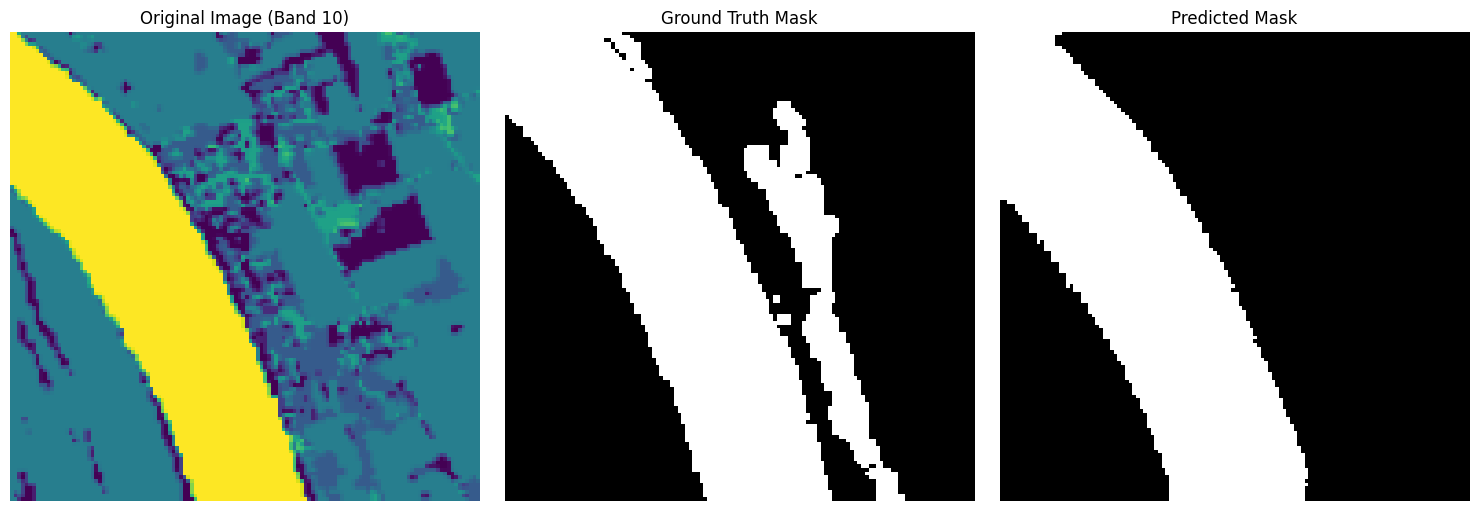

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


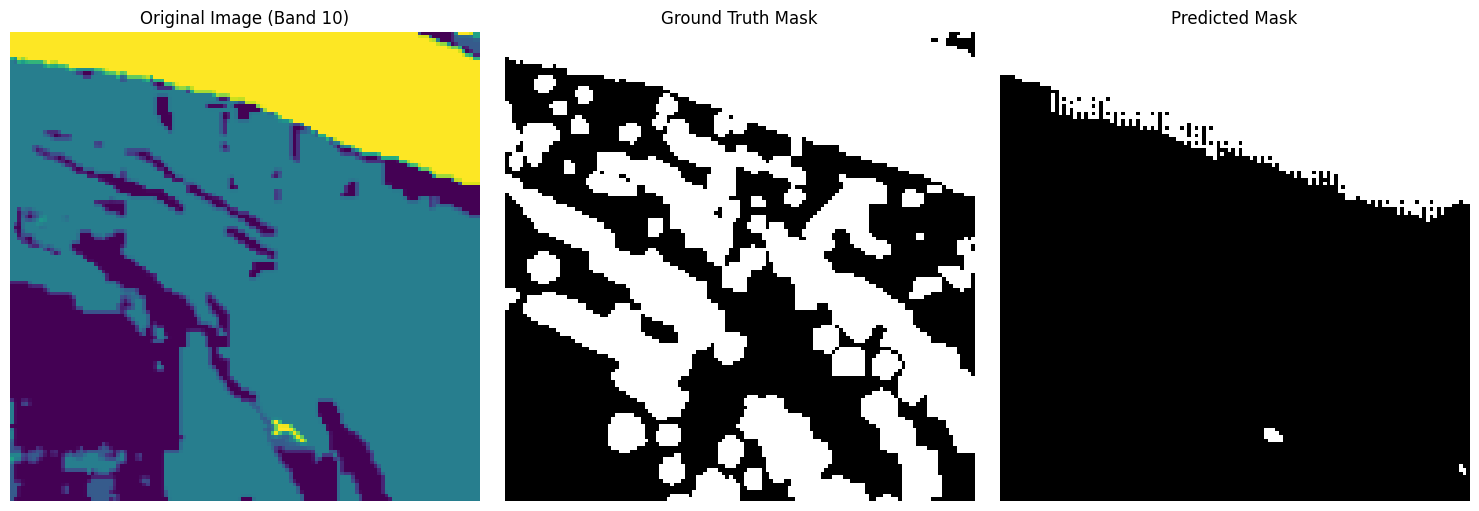

Visualization of prediction examples completed.


In [27]:
for sample_images, sample_masks in val_dataset.take(1):
    for i in range(min(len(sample_images), 3)):
        image = sample_images[i]
        true_mask = sample_masks[i]

        predicted_mask = model.predict(tf.expand_dims(image, axis=0))[0]
        predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

        plt.figure(figsize=(15, 5))

        # Display original image (Band 3 for example)
        plt.subplot(1, 3, 1)
        plt.imshow(image[:, :, 10])
        plt.title("Original Image (Band 10)")
        plt.axis('off')

        # Display ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')


        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask_binary.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

print("Visualization of prediction examples completed.")

In [25]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import numpy as np

all_true_masks = []
all_predicted_masks = []

print("Evaluating model performance on validation dataset...")

for sample_images, sample_masks in val_dataset:
    predicted_masks = model.predict(sample_images)
    predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)
    all_true_masks.append(sample_masks.numpy().flatten())
    all_predicted_masks.append(predicted_masks_binary.flatten())

all_true_masks = np.concatenate(all_true_masks)
all_predicted_masks = np.concatenate(all_predicted_masks)

iou_water = jaccard_score(all_true_masks, all_predicted_masks, pos_label=1, average='binary')
precision_water = precision_score(all_true_masks, all_predicted_masks, pos_label=1, average='binary')
recall_water = recall_score(all_true_masks, all_predicted_masks, pos_label=1, average='binary')
f1_water = f1_score(all_true_masks, all_predicted_masks, pos_label=1, average='binary')


print("\nClass-Specific Evaluation Results (Water Class):")
print(f"  IoU (Water): {iou_water:.4f}")
print(f"  Precision (Water): {precision_water:.4f}")
print(f"  Recall (Water): {recall_water:.4f}")
print(f"  F1-score (Water): {f1_water:.4f}")

Evaluating model performance on validation dataset...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step

Class-Specific Evaluation Results (Water Class):
  IoU (Water): 0.5713
  Precision (Water): 0.8558
  Recall (Water): 0.6321
  F1-score (Water): 0.7271


## Deeplab model:

In [37]:
def build_backbone(input_shape):
    """Builds a modified ResNet backbone for DeepLabV3+."""
    inputs = tf.keras.Input(shape=input_shape, name="backbone_input")

    # Initial convolution and pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False, name="backbone_conv1")(inputs)
    x = layers.BatchNormalization(name="backbone_bn1")(x)
    x = layers.ReLU(name="backbone_relu1")(x)
    low_level_features = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name="backbone_pool1")(x) # This will be our low-level feature output

    # Residual blocks (simplified for demonstration)
    # Block 1
    identity = low_level_features
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False, name="backbone_conv2_1")(low_level_features)
    x = layers.BatchNormalization(name="backbone_bn2_1")(x)
    x = layers.ReLU(name="backbone_relu2_1")(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False, name="backbone_conv2_2")(x)
    x = layers.BatchNormalization(name="backbone_bn2_2")(x)
    x = layers.add([x, identity], name="backbone_add1")
    x = layers.ReLU(name="backbone_relu2_2")(x)

    # Block 2 (with downsampling)
    identity = layers.Conv2D(128, (1, 1), strides=(2, 2), use_bias=False, name="backbone_conv3_0")(x) # Projection shortcut
    identity = layers.BatchNormalization(name="backbone_bn3_0")(identity)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False, name="backbone_conv3_1")(x)
    x = layers.BatchNormalization(name="backbone_bn3_1")(x)
    x = layers.ReLU(name="backbone_relu3_1")(x)
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False, name="backbone_conv3_2")(x)
    x = layers.BatchNormalization(name="backbone_bn3_2")(x)
    x = layers.add([x, identity], name="backbone_add2")
    x = layers.ReLU(name="backbone_relu3_2")(x)

    # Return the model object
    return tf.keras.Model(inputs=inputs, outputs=[low_level_features, x], name="backbone")

def atrous_spatial_pyramid_pooling(inputs):
    input_shape = inputs.shape
    target_height = input_shape[1]
    target_width = input_shape[2]

    # 1x1 convolution branch
    conv1x1 = layers.Conv2D(256, (1, 1), padding='same', use_bias=False, name="aspp_conv1x1")(inputs)
    conv1x1 = layers.BatchNormalization(name="aspp_bn1")(conv1x1)
    conv1x1 = layers.ReLU(name="aspp_relu1")(conv1x1)

    # 3x3 atrous convolution branches with different rates
    atrous_rates = [6, 12, 18]
    atrous_outputs = []
    for i, rate in enumerate(atrous_rates):
        atrous_conv = layers.Conv2D(256, (3, 3), strides=(1, 1), dilation_rate=rate, padding='same', use_bias=False, name=f"aspp_atrous_conv{i+1}")(inputs)
        atrous_conv = layers.BatchNormalization(name=f"aspp_bn{i+2}")(atrous_conv)
        atrous_conv = layers.ReLU(name=f"aspp_relu{i+2}")(atrous_conv)
        atrous_outputs.append(atrous_conv)

    # Global average pooling branch
    global_avg_pool = layers.GlobalAveragePooling2D(name="aspp_global_avg_pool")(inputs)
    global_avg_pool = layers.Reshape((1, 1, input_shape[-1]), name="aspp_reshape")(global_avg_pool)
    global_avg_pool = layers.Conv2D(256, (1, 1), padding='same', use_bias=False, name="aspp_pool_conv1x1")(global_avg_pool)
    global_avg_pool = layers.BatchNormalization(name="aspp_bn5")(global_avg_pool) # Assuming 3 atrous convs + 1x1 conv + pool conv
    global_avg_pool = layers.ReLU(name="aspp_relu5")(global_avg_pool)
    global_avg_pool = layers.Resizing(target_height, target_width, interpolation='bilinear', name="aspp_pool_resize")(global_avg_pool)


    # Concatenate all branches
    concatenated = layers.concatenate([conv1x1] + atrous_outputs + [global_avg_pool], name="aspp_concatenate")

    # Final 1x1 convolution after concatenation
    output = layers.Conv2D(256, (1, 1), padding='same', use_bias=False, name="aspp_final_conv1x1")(concatenated)
    output = layers.BatchNormalization(name="aspp_final_bn")(output)
    output = layers.ReLU(name="aspp_final_relu")(output)

    # Return the output tensor
    return output


def build_deeplabv3plus(input_shape):
    inputs = tf.keras.Input(shape=input_shape, name="input_image")

    # Build Backbone model
    backbone = build_backbone(input_shape)
    low_level_features, high_level_features = backbone(inputs)

    # Build ASPP Module and get output tensor
    aspp_output = atrous_spatial_pyramid_pooling(high_level_features)

    # Build Decoder
    # 1. Apply 1x1 convolution and batch normalization to low-level features
    low_level_features_processed = layers.Conv2D(48, (1, 1), padding='same', use_bias=False, name="decoder_low_conv1x1")(low_level_features)
    low_level_features_processed = layers.BatchNormalization(name="decoder_low_bn1")(low_level_features_processed)
    low_level_features_processed = layers.ReLU(name="decoder_low_relu1")(low_level_features_processed)

    # 3. Upsample the output of the ASPP module
    # Get the static spatial dimensions from the shape attribute
    low_level_shape = low_level_features_processed.shape
    target_height = low_level_shape[1]
    target_width = low_level_shape[2]

    # Use Resizing layer which is compatible with Functional API
    upsampled_aspp = layers.Resizing(target_height, target_width, interpolation='bilinear', name="decoder_aspp_resize")(aspp_output)


    # 4. Concatenate the processed low-level features and the upsampled ASPP output
    concatenated = layers.concatenate([upsampled_aspp, low_level_features_processed], name="decoder_concatenate")

    # 5. Apply one or more 3x3 convolutions, batch normalization, and ReLU
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', use_bias=False, name="decoder_conv1")(concatenated)
    x = layers.BatchNormalization(name="decoder_bn1")(x)
    x = layers.ReLU(name="decoder_relu1")(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', use_bias=False, name="decoder_conv2")(x)
    x = layers.BatchNormalization(name="decoder_bn2")(x)
    x = layers.ReLU(name="decoder_relu2")(x)

    # 6. Apply a final 1x1 convolution with a single filter and a sigmoid activation
    output = layers.Conv2D(1, (1, 1), activation='sigmoid', name="decoder_output_conv")(x)

    # The final output needs to be upsampled to the original input image size
    # Get original input shape from the input_shape argument
    original_height = input_shape[0]
    original_width = input_shape[1]

    output = layers.Resizing(original_height, original_width, interpolation='bilinear', name="final_output_resize")(output)


    model = tf.keras.Model(inputs=inputs, outputs=output, name="DeepLabV3Plus")
    return model

# Instantiate the full DeepLabV3+ model
input_shape = images3[0].shape # Use the actual shape of the loaded images
deeplabv3plus_model = build_deeplabv3plus(input_shape)

# Print the model summary
deeplabv3plus_model.summary()

Model: "DeepLabV3Plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ backbone            │ [(None, 32, 32,   │    343,040 │ input_image[0][0] │
│ (Functional)        │ 64), (None, 16,   │            │                   │
│                     │ 16, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_global_avg_po… │ (None, 128)       │          0 │ backbone[0][1]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_reshape        │ (None, 1, 1, 128) │          0 │ aspp_global_avg_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_pool_conv1x1   │ (None, 1, 1, 256) │     32,768 │ aspp_reshape[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_conv1x1        │ (None, 16, 16,    │     32,768 │ backbone[0][1]    │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_atrous_conv1   │ (None, 16, 16,    │    294,912 │ backbone[0][1]    │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_atrous_conv2   │ (None, 16, 16,    │    294,912 │ backbone[0][1]    │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_atrous_conv3   │ (None, 16, 16,    │    294,912 │ backbone[0][1]    │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn5            │ (None, 1, 1, 256) │      1,024 │ aspp_pool_conv1x… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn1            │ (None, 16, 16,    │      1,024 │ aspp_conv1x1[0][… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn2            │ (None, 16, 16,    │      1,024 │ aspp_atrous_conv… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn3            │ (None, 16, 16,    │      1,024 │ aspp_atrous_conv… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn4            │ (None, 16, 16,    │      1,024 │ aspp_atrous_conv… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_relu5 (ReLU)   │ (None, 1, 1, 256) │          0 │ aspp_bn5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_relu1 (ReLU)   │ (None, 16, 16,    │          0 │ aspp_bn1[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_relu2 (ReLU)   │ (None, 16, 16,    │          0 │ aspp_bn2[0][0]  

 Total params: 2,922,945 (11.15 MB)

 Trainable params: 2,917,601 (11.13 MB)

 Non-trainable params: 5,344 (20.88 KB)

In [38]:
deeplabv3plus_model.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

EPOCHS = 50
print(f"Starting training for {EPOCHS} epochs...")
history = deeplabv3plus_model.fit(train_dataset,
                                  epochs=EPOCHS,
                                  validation_data=val_dataset)
print("Model training completed.")

evaluation_results = deeplabv3plus_model.evaluate(val_dataset)

print("\nEvaluation Results on Validation Dataset:")
print(f"  Loss: {evaluation_results[0]:.4f}")
print(f"  Accuracy: {evaluation_results[1]:.4f}")
print(f"  MeanIoU: {evaluation_results[2]:.4f}")

Starting training for 50 epochs...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7381 - loss: 0.6693 - mean_io_u_1: 0.3994 - val_accuracy: 0.7638 - val_loss: 0.6025 - val_mean_io_u_1: 0.3819
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8747 - loss: 0.3886 - mean_io_u_1: 0.3974 - val_accuracy: 0.7638 - val_loss: 0.5495 - val_mean_io_u_1: 0.3819
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8847 - loss: 0.2946 - mean_io_u_1: 0.3696 - val_accuracy: 0.7638 - val_loss: 0.5891 - val_mean_io_u_1: 0.3819
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8883 - loss: 0.2801 - mean_io_u_1: 0.3691 - val_accuracy: 0.7638 - val_loss: 0.6979 - val_mean_io_u_1: 0.3819
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8902 - loss: 0.2582 - mean_io_u_1: 0.3689 - val_accuracy: 0.7638 - val_loss: 0.6731 - val_mean_io_u_1: 0.3819
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8938 - loss: 0.2456 - mean

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


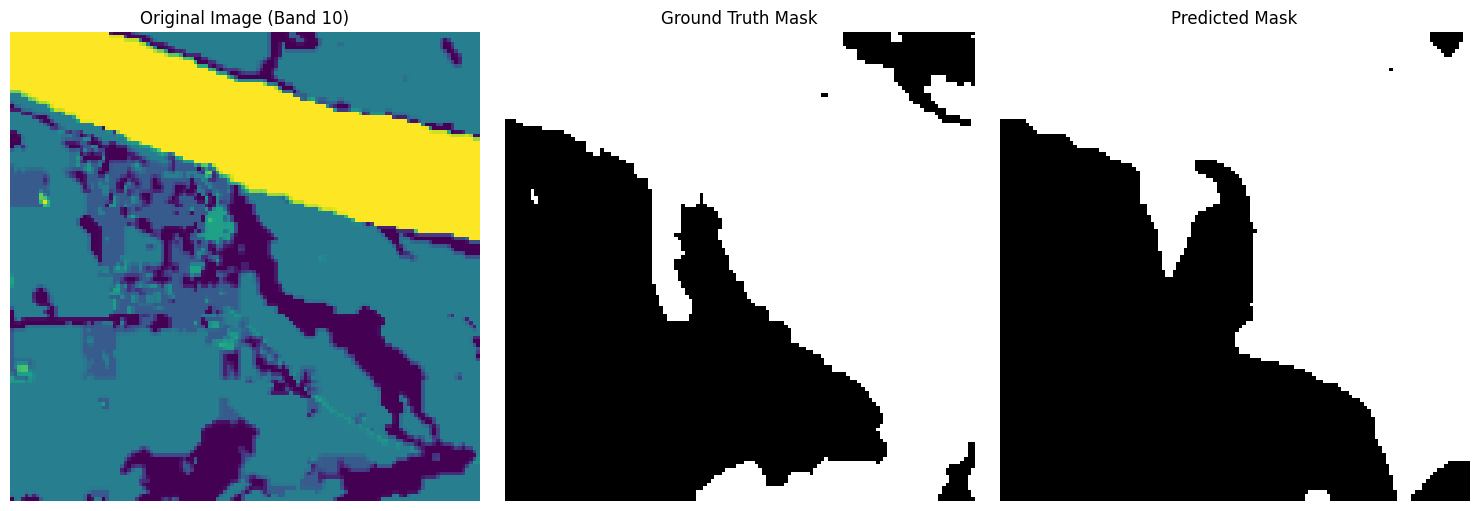

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


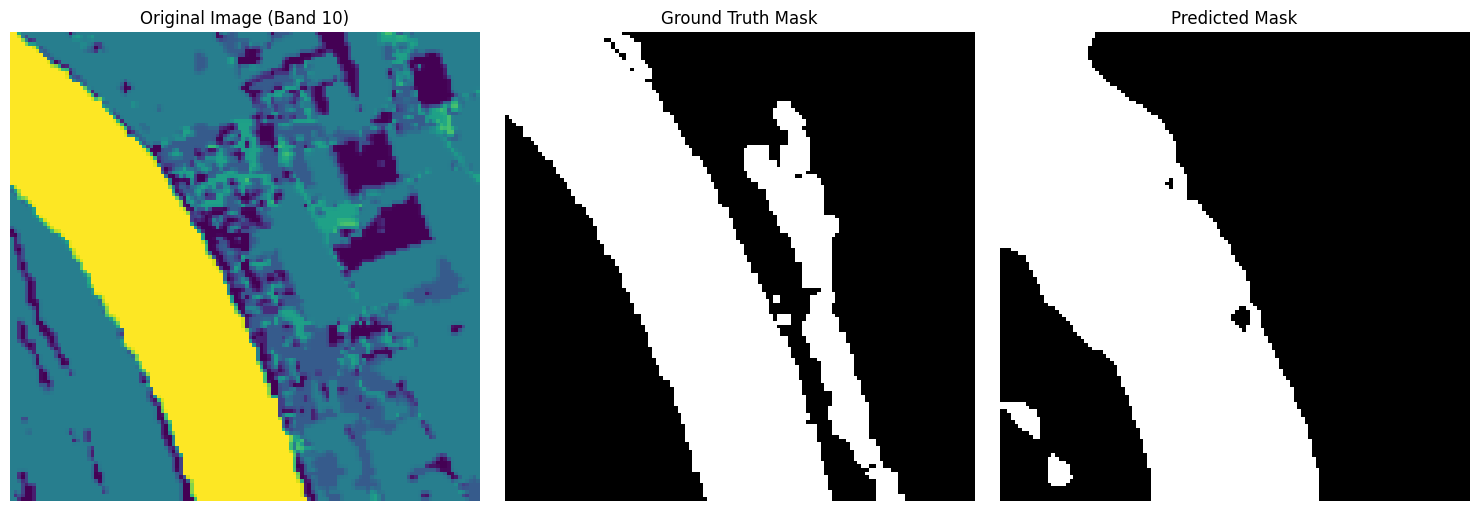

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


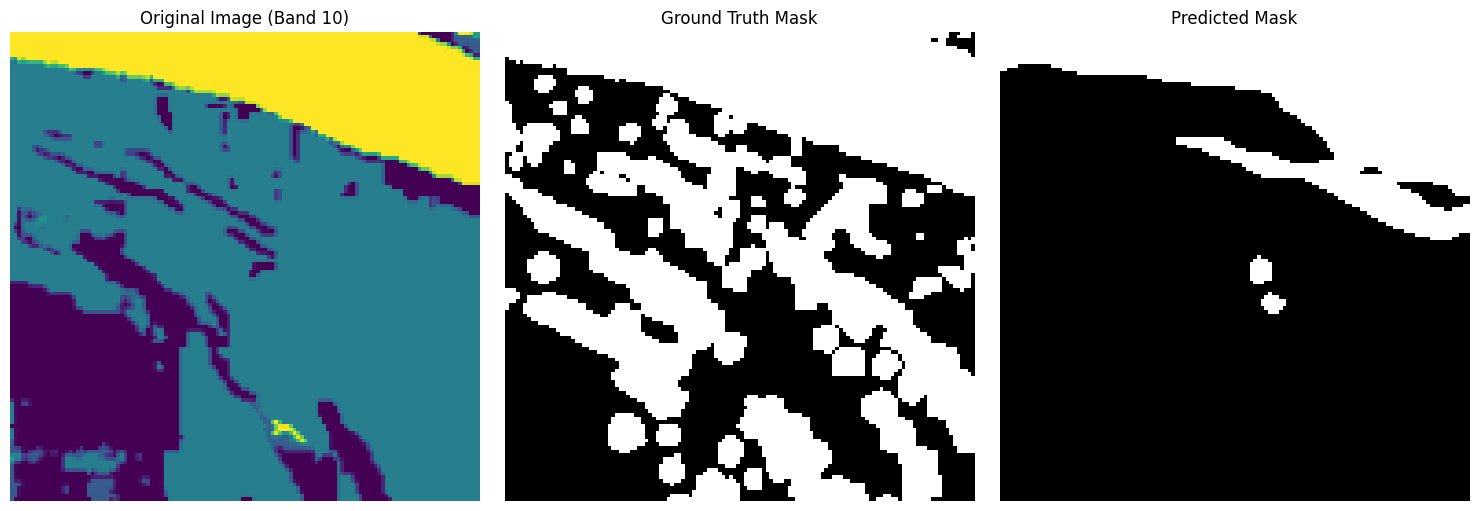

Visualization of DeepLabV3+ prediction examples completed.


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def display_predictions(model, dataset, num_examples=3):
       for sample_images, sample_masks in dataset.take(1):
        for i in range(min(len(sample_images), num_examples)):
            image = sample_images[i]
            true_mask = sample_masks[i]
            predicted_mask = model.predict(tf.expand_dims(image, axis=0))[0]
            predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image[:, :, 10])
            plt.title("Original Image (Band 10)")
            plt.axis('off')


            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')


            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask_binary.squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

display_predictions(deeplabv3plus_model, val_dataset, num_examples=3)

print("Visualization of DeepLabV3+ prediction examples completed.")

In [40]:
DATASET_SIZE = len(images3)
TEST_SIZE = int(0.2 * DATASET_SIZE)
TRAIN_VAL_SIZE = DATASET_SIZE - TEST_SIZE
TRAIN_SIZE_NEW = int(0.8 * TRAIN_VAL_SIZE)
VAL_SIZE_NEW = TRAIN_VAL_SIZE - TRAIN_SIZE_NEW

BATCH_SIZE = 16
BUFFER_SIZE = tf.data.AUTOTUNE

test_dataset = augmented_dataset.take(TEST_SIZE)
train_val_dataset = augmented_dataset.skip(TEST_SIZE)

train_dataset_new = train_val_dataset.take(TRAIN_SIZE_NEW)
val_dataset_new = train_val_dataset.skip(TRAIN_SIZE_NEW)

train_dataset_new = train_dataset_new.batch(BATCH_SIZE).cache().prefetch(buffer_size=BUFFER_SIZE)
val_dataset_new = val_dataset_new.batch(BATCH_SIZE).cache().prefetch(buffer_size=BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=BUFFER_SIZE)

print(f"New Training dataset size: {tf.data.experimental.cardinality(train_dataset_new).numpy() * BATCH_SIZE}")
print(f"New Validation dataset size: {tf.data.experimental.cardinality(val_dataset_new).numpy() * BATCH_SIZE}")
print(f"Test dataset size: {tf.data.experimental.cardinality(test_dataset).numpy() * BATCH_SIZE}")

New Training dataset size: 208
New Validation dataset size: 64
Test dataset size: 64


In [41]:
normalized_test_dataset = dataset.map(normalize)
augmented_test_dataset = normalized_test_dataset.map(augment)
print("Normalization and augmentation applied to the test dataset (implicitly, as it was split from the augmented dataset).")

Normalization and augmentation applied to the test dataset (implicitly, as it was split from the augmented dataset).


In [42]:
all_true_masks_test = []
all_predicted_masks_test = []

print("Evaluating DeepLabV3+ model performance on test dataset...")

for sample_images_test, sample_masks_test in test_dataset:
    predicted_masks_test = deeplabv3plus_model.predict(sample_images_test)
    hold the predicted masks to get binary masks (assuming sigmoid output)
    predicted_masks_binary_test = (predicted_masks_test > 0.5).astype(np.uint8)

    all_true_masks_test.append(sample_masks_test.numpy().flatten())
    all_predicted_masks_test.append(predicted_masks_binary_test.flatten())


all_true_masks_test_flat = np.concatenate(all_true_masks_test)
all_predicted_masks_test_flat = np.concatenate(all_predicted_masks_test)


iou_water_test = jaccard_score(all_true_masks_test_flat, all_predicted_masks_test_flat, pos_label=1, average='binary')
precision_water_test = precision_score(all_true_masks_test_flat, all_predicted_masks_test_flat, pos_label=1, average='binary')
recall_water_test = recall_score(all_true_masks_test_flat, all_predicted_masks_test_flat, pos_label=1, average='binary')
f1_water_test = f1_score(all_true_masks_test_flat, all_predicted_masks_test_flat, pos_label=1, average='binary')


print("\nDeepLabV3+ Class-Specific Evaluation Results on Test Dataset (Water Class):")
print(f"  IoU (Water): {iou_water_test:.4f}")
print(f"  Precision (Water): {precision_water_test:.4f}")
print(f"  Recall (Water): {recall_water_test:.4f}")
print(f"  F1-score (Water): {f1_water_test:.4f}")


Evaluating DeepLabV3+ model performance on test dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

DeepLabV3+ Class-Specific Evaluation Results on Test Dataset (Water Class):
  IoU (Water): 0.6066
  Precision (Water): 0.8453
  Recall (Water): 0.6824
  F1-score (Water): 0.7552
